# Week3 복습과제 GAN

### 라이브러리 호출

In [1]:
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import matplotlib

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 변수 값 설정

In [2]:
batch_size = 512
epochs = 200
sample_size = 64
nz = 128
k = 1

### 데이터 내려받기 + 정규화

In [3]:
transform = transforms. Compose([
    transforms.ToTensor(),
    transforms. Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(
  root="/content/drive/MyDrive/Euron-Data/chap13/data", train=True, transform=transform, download=True)


train_loader = DataLoader (
  train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 생성자 네트워크

In [4]:
class Generator(nn.Module):
  def __init__(self, nz):
    super(Generator, self).__init__()
    self.nz = nz
    self.main = nn.Sequential(
        nn.Linear(self.nz, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
  def forward(self, x):
    return self.main(x).view(-1,1,28,28)

### 판별자 네트워크

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_input = 784
    self.main = nn.Sequential(
        nn.Linear(self.n_input, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = x.view(-1, 784)
    return self.main(x)

### 생성자 & 판별자 네트워크 초기화

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


### 옵티마이저 & 손실 함수

In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

### 생성 이미지 저장 함수

In [8]:
def save_generator_image(image, path):
  save_image(image, path)

### 판별자 학습을 위한 함수

In [9]:
def train_discriminator(optimizer, data_real, data_fake):
  b_size = data_real.size(0)
  real_label = torch.ones(b_size, 1).to(device)
  fake_label = torch.zeros(b_size, 1).to(device)
  optimizer.zero_grad()
  output_real = discriminator(data_real)
  loss_real = criterion(output_real, real_label)
  output_fake = discriminator(data_fake)
  loss_fake = criterion(output_fake, fake_label)
  loss_real.backward()
  loss_fake.backward()
  optimizer.step()
  return loss_real + loss_fake

### 생성자 학습을 위한 함수

In [10]:
def train_generator(optimizer, data_fake):
  b_size = data_fake.size(0)
  real_label = torch.ones(b_size, 1).to(device)
  optimizer.zero_grad()
  output = discriminator(data_fake)
  loss = criterion(output, real_label)
  loss.backward()
  optimizer.step()
  return loss

### 모델 학습

In [11]:
generator.train()
discriminator.train()

for epoch in range(epochs):
  loss_g = 0.0
  loss_d = 0.0
  for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
    image, _ = data
    image = image.to(device)
    b_size = len(image)
    for step in range(k):
      data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
      data_real = image
      loss_d += train_discriminator(optim_d, data_real, data_fake)
    data_fake = generator(torch.randn(b_size, nz).to(device))
    loss_g += train_generator(optim_g, data_fake)
  generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
  generated_img = make_grid(generated_img)
  save_generator_image(generated_img, f"/content/drive/MyDrive/Euron-Data/chap13/img/gen_img{epoch}.png")
  images.append(generated_img)
  epoch_loss_g = loss_g / idx
  epoch_loss_d = loss_d / idx
  losses_g.append(epoch_loss_g)
  losses_d.append(epoch_loss_d)

  print(f"Epoch {epoch} of {epochs}")
  print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:14,  8.32it/s]                         

Epoch 0 of 200
Generator loss: 1.34967566, Discriminator loss: 0.90843177



118it [00:11, 10.11it/s]                         

Epoch 1 of 200
Generator loss: 2.03834581, Discriminator loss: 1.47654259



118it [00:10, 11.00it/s]                         

Epoch 2 of 200
Generator loss: 2.37820077, Discriminator loss: 0.96056664



118it [00:11, 10.24it/s]                         

Epoch 3 of 200
Generator loss: 1.37481642, Discriminator loss: 0.99339628



118it [00:12,  9.65it/s]                         

Epoch 4 of 200
Generator loss: 2.35563850, Discriminator loss: 1.27586627



118it [00:11,  9.99it/s]                         

Epoch 5 of 200
Generator loss: 2.03054690, Discriminator loss: 0.87932420



118it [00:11, 10.04it/s]                         


Epoch 6 of 200
Generator loss: 0.98847622, Discriminator loss: 1.22101045


118it [00:11,  9.95it/s]                         

Epoch 7 of 200
Generator loss: 1.33060145, Discriminator loss: 1.22646976



118it [00:11, 10.67it/s]                         

Epoch 8 of 200
Generator loss: 1.40558028, Discriminator loss: 0.92574543



118it [00:11, 10.41it/s]                         

Epoch 9 of 200
Generator loss: 1.05081153, Discriminator loss: 1.27201200



118it [00:11,  9.88it/s]                         

Epoch 10 of 200
Generator loss: 3.36214471, Discriminator loss: 1.02166057



118it [00:11,  9.93it/s]                         

Epoch 11 of 200
Generator loss: 2.91484952, Discriminator loss: 1.28013957



118it [00:11,  9.84it/s]                         

Epoch 12 of 200
Generator loss: 1.59014249, Discriminator loss: 1.17995989



118it [00:11,  9.88it/s]                         

Epoch 13 of 200
Generator loss: 1.23649919, Discriminator loss: 0.98956931



118it [00:11, 10.10it/s]                         

Epoch 14 of 200
Generator loss: 1.54804265, Discriminator loss: 1.04202044



118it [00:10, 10.84it/s]                         

Epoch 15 of 200
Generator loss: 2.13267899, Discriminator loss: 0.85579062



118it [00:11, 10.10it/s]                         

Epoch 16 of 200
Generator loss: 1.83349073, Discriminator loss: 0.79625314



118it [00:12,  9.79it/s]                         

Epoch 17 of 200
Generator loss: 2.47680044, Discriminator loss: 0.77692455



118it [00:11,  9.88it/s]                         

Epoch 18 of 200
Generator loss: 2.10813904, Discriminator loss: 0.77480906



118it [00:11,  9.97it/s]                         

Epoch 19 of 200
Generator loss: 1.94470274, Discriminator loss: 0.80061024



118it [00:12,  9.79it/s]

Epoch 20 of 200
Generator loss: 2.18869305, Discriminator loss: 0.62714291



118it [00:11, 10.62it/s]                         

Epoch 21 of 200
Generator loss: 2.61173344, Discriminator loss: 0.47276509



118it [00:11, 10.69it/s]                         

Epoch 22 of 200
Generator loss: 3.50708461, Discriminator loss: 0.29890561



118it [00:11, 10.02it/s]                         

Epoch 23 of 200
Generator loss: 3.38445616, Discriminator loss: 0.51159757



118it [00:11, 10.01it/s]                         


Epoch 24 of 200
Generator loss: 2.29783392, Discriminator loss: 0.66794455


118it [00:11, 10.02it/s]                         

Epoch 25 of 200
Generator loss: 2.57404876, Discriminator loss: 0.67493004



118it [00:11,  9.86it/s]                         

Epoch 26 of 200
Generator loss: 2.66632771, Discriminator loss: 0.53030860



118it [00:11, 10.37it/s]                         

Epoch 27 of 200
Generator loss: 2.55724049, Discriminator loss: 0.51773697



118it [00:10, 11.15it/s]                         


Epoch 28 of 200
Generator loss: 2.99385428, Discriminator loss: 0.57943416


118it [00:11, 10.01it/s]                         

Epoch 29 of 200
Generator loss: 2.64496827, Discriminator loss: 0.57998580



118it [00:11, 10.10it/s]                         

Epoch 30 of 200
Generator loss: 3.08754587, Discriminator loss: 0.47962508



118it [00:11, 10.12it/s]                         

Epoch 31 of 200
Generator loss: 2.66542482, Discriminator loss: 0.55184299



118it [00:11, 10.17it/s]                         

Epoch 32 of 200
Generator loss: 2.50777245, Discriminator loss: 0.61992985



118it [00:11, 10.13it/s]                         

Epoch 33 of 200
Generator loss: 2.59547687, Discriminator loss: 0.61655605



118it [00:10, 11.11it/s]                         

Epoch 34 of 200
Generator loss: 3.09348321, Discriminator loss: 0.55986071



118it [00:11, 10.10it/s]                         

Epoch 35 of 200
Generator loss: 2.42410326, Discriminator loss: 0.65647143



118it [00:12,  9.74it/s]                         

Epoch 36 of 200
Generator loss: 2.51581073, Discriminator loss: 0.55851728



118it [00:12,  9.83it/s]                         


Epoch 37 of 200
Generator loss: 2.84303236, Discriminator loss: 0.56672931


118it [00:12,  9.66it/s]                         

Epoch 38 of 200
Generator loss: 2.77357531, Discriminator loss: 0.56896335



118it [00:11,  9.84it/s]                         


Epoch 39 of 200
Generator loss: 2.89288330, Discriminator loss: 0.53250074


118it [00:11,  9.90it/s]                         

Epoch 40 of 200
Generator loss: 2.91937566, Discriminator loss: 0.48241112



118it [00:11, 10.57it/s]                         

Epoch 41 of 200
Generator loss: 3.21423435, Discriminator loss: 0.52181846



118it [00:11, 10.18it/s]                         

Epoch 42 of 200
Generator loss: 3.28853369, Discriminator loss: 0.49001133



118it [00:12,  9.75it/s]                         

Epoch 43 of 200
Generator loss: 2.98807144, Discriminator loss: 0.51535922



118it [00:11,  9.87it/s]                         

Epoch 44 of 200
Generator loss: 3.20283556, Discriminator loss: 0.48988712



118it [00:11,  9.93it/s]                         

Epoch 45 of 200
Generator loss: 3.46845198, Discriminator loss: 0.42596439



118it [00:12,  9.81it/s]                         

Epoch 46 of 200
Generator loss: 3.27126575, Discriminator loss: 0.44223964



118it [00:11, 10.37it/s]                         


Epoch 47 of 200
Generator loss: 2.99743509, Discriminator loss: 0.53096610


118it [00:10, 10.88it/s]                         

Epoch 48 of 200
Generator loss: 2.89544773, Discriminator loss: 0.54756820



118it [00:11, 10.29it/s]                         

Epoch 49 of 200
Generator loss: 2.86142588, Discriminator loss: 0.54245448



118it [00:11, 10.14it/s]                         

Epoch 50 of 200
Generator loss: 3.37567306, Discriminator loss: 0.41855934



118it [00:11, 10.00it/s]                         

Epoch 51 of 200
Generator loss: 3.29722810, Discriminator loss: 0.46329507



118it [00:11,  9.90it/s]                         

Epoch 52 of 200
Generator loss: 3.08538771, Discriminator loss: 0.47595096



118it [00:11,  9.98it/s]                         


Epoch 53 of 200
Generator loss: 3.04422069, Discriminator loss: 0.53213108


118it [00:11, 10.50it/s]                         

Epoch 54 of 200
Generator loss: 3.09558010, Discriminator loss: 0.53168094



118it [00:10, 10.82it/s]


Epoch 55 of 200
Generator loss: 3.13570929, Discriminator loss: 0.46481818


118it [00:11,  9.90it/s]                         

Epoch 56 of 200
Generator loss: 3.13179612, Discriminator loss: 0.48890579



118it [00:11, 10.07it/s]                         


Epoch 57 of 200
Generator loss: 3.12736368, Discriminator loss: 0.48705855


118it [00:11, 10.03it/s]                         

Epoch 58 of 200
Generator loss: 3.18482733, Discriminator loss: 0.47206819



118it [00:11,  9.98it/s]                         

Epoch 59 of 200
Generator loss: 3.04859066, Discriminator loss: 0.51794165



118it [00:11, 10.20it/s]                         

Epoch 60 of 200
Generator loss: 2.92312026, Discriminator loss: 0.54964322



118it [00:10, 10.77it/s]                         

Epoch 61 of 200
Generator loss: 2.97964573, Discriminator loss: 0.59266853



118it [00:11, 10.40it/s]                         

Epoch 62 of 200
Generator loss: 2.95751905, Discriminator loss: 0.57091445



118it [00:11,  9.84it/s]                         

Epoch 63 of 200
Generator loss: 2.75326014, Discriminator loss: 0.54021853



118it [00:11, 10.05it/s]


Epoch 64 of 200
Generator loss: 2.79735565, Discriminator loss: 0.53226346


118it [00:11,  9.94it/s]                         

Epoch 65 of 200
Generator loss: 2.84261608, Discriminator loss: 0.50773412



118it [00:11, 10.01it/s]                         

Epoch 66 of 200
Generator loss: 2.75765252, Discriminator loss: 0.54470009



118it [00:11, 10.12it/s]                         

Epoch 67 of 200
Generator loss: 2.75118542, Discriminator loss: 0.53683621



118it [00:10, 10.91it/s]                         

Epoch 68 of 200
Generator loss: 2.77918124, Discriminator loss: 0.56625080



118it [00:11, 10.10it/s]                         

Epoch 69 of 200
Generator loss: 2.65144587, Discriminator loss: 0.60295051



118it [00:11, 10.16it/s]                         

Epoch 70 of 200
Generator loss: 2.58247185, Discriminator loss: 0.60512453



118it [00:11, 10.02it/s]                         

Epoch 71 of 200
Generator loss: 2.57533193, Discriminator loss: 0.63071537



118it [00:11, 10.09it/s]                         

Epoch 72 of 200
Generator loss: 2.41876101, Discriminator loss: 0.67762256



118it [00:11, 10.03it/s]                         


Epoch 73 of 200
Generator loss: 2.38552904, Discriminator loss: 0.64398366


118it [00:11, 10.54it/s]                         

Epoch 74 of 200
Generator loss: 2.51428127, Discriminator loss: 0.59405351



118it [00:11, 10.65it/s]                         


Epoch 75 of 200
Generator loss: 2.61484790, Discriminator loss: 0.57810235


118it [00:11,  9.88it/s]                         

Epoch 76 of 200
Generator loss: 2.55730009, Discriminator loss: 0.62289739



118it [00:11,  9.92it/s]


Epoch 77 of 200
Generator loss: 2.63220811, Discriminator loss: 0.62203974


118it [00:11, 10.04it/s]                         


Epoch 78 of 200
Generator loss: 2.54214978, Discriminator loss: 0.61739528


118it [00:12,  9.78it/s]                         

Epoch 79 of 200
Generator loss: 2.73802900, Discriminator loss: 0.58173472



118it [00:11, 10.16it/s]                         

Epoch 80 of 200
Generator loss: 2.72072172, Discriminator loss: 0.58723283



118it [00:10, 10.86it/s]                         


Epoch 81 of 200
Generator loss: 2.50391626, Discriminator loss: 0.63099372


118it [00:11, 10.21it/s]                         

Epoch 82 of 200
Generator loss: 2.48245549, Discriminator loss: 0.65255016



118it [00:11,  9.88it/s]                         

Epoch 83 of 200
Generator loss: 2.44390750, Discriminator loss: 0.66437447



118it [00:12,  9.80it/s]                         

Epoch 84 of 200
Generator loss: 2.36015010, Discriminator loss: 0.68246168



118it [00:11,  9.92it/s]                         

Epoch 85 of 200
Generator loss: 2.26282001, Discriminator loss: 0.69326746



118it [00:12,  9.83it/s]


Epoch 86 of 200
Generator loss: 2.25368357, Discriminator loss: 0.67831194


118it [00:11, 10.09it/s]                         


Epoch 87 of 200
Generator loss: 2.22201490, Discriminator loss: 0.67725772


118it [00:10, 10.94it/s]

Epoch 88 of 200
Generator loss: 2.22664452, Discriminator loss: 0.70027244



118it [00:11,  9.99it/s]                         

Epoch 89 of 200
Generator loss: 2.29067254, Discriminator loss: 0.72160625



118it [00:11,  9.89it/s]                         

Epoch 90 of 200
Generator loss: 2.10260963, Discriminator loss: 0.76195389



118it [00:11, 10.16it/s]                         

Epoch 91 of 200
Generator loss: 2.15380692, Discriminator loss: 0.72690725



118it [00:12,  9.80it/s]                         

Epoch 92 of 200
Generator loss: 2.15160823, Discriminator loss: 0.73031843



118it [00:11, 10.06it/s]                         

Epoch 93 of 200
Generator loss: 2.26686859, Discriminator loss: 0.70469820



118it [00:11, 10.07it/s]                         

Epoch 94 of 200
Generator loss: 2.24822354, Discriminator loss: 0.70919752



118it [00:10, 11.13it/s]                         

Epoch 95 of 200
Generator loss: 2.21017170, Discriminator loss: 0.71118611



118it [00:11, 10.23it/s]                         

Epoch 96 of 200
Generator loss: 2.22287965, Discriminator loss: 0.71633595



118it [00:11, 10.00it/s]


Epoch 97 of 200
Generator loss: 2.10937548, Discriminator loss: 0.74033016


118it [00:11, 10.11it/s]                         

Epoch 98 of 200
Generator loss: 2.20893073, Discriminator loss: 0.74862695



118it [00:11, 10.07it/s]                         

Epoch 99 of 200
Generator loss: 1.98169303, Discriminator loss: 0.81727058



118it [00:11,  9.87it/s]


Epoch 100 of 200
Generator loss: 1.91803873, Discriminator loss: 0.79778314


118it [00:11, 10.20it/s]                         

Epoch 101 of 200
Generator loss: 2.04254627, Discriminator loss: 0.74713260



118it [00:11, 10.27it/s]                         

Epoch 102 of 200
Generator loss: 1.99852383, Discriminator loss: 0.78167880



118it [00:11, 10.19it/s]                         

Epoch 103 of 200
Generator loss: 1.96514106, Discriminator loss: 0.80196083



118it [00:12,  9.75it/s]                         

Epoch 104 of 200
Generator loss: 1.95791709, Discriminator loss: 0.79574710



118it [00:12,  9.65it/s]                         

Epoch 105 of 200
Generator loss: 1.83898151, Discriminator loss: 0.84514964



118it [00:11,  9.93it/s]                         

Epoch 106 of 200
Generator loss: 1.87366652, Discriminator loss: 0.85396159



118it [00:12,  9.82it/s]                         

Epoch 107 of 200
Generator loss: 1.84122586, Discriminator loss: 0.83263028



118it [00:11,  9.89it/s]                         

Epoch 108 of 200
Generator loss: 1.83672559, Discriminator loss: 0.84753710



118it [00:10, 10.80it/s]                         

Epoch 109 of 200
Generator loss: 1.77771878, Discriminator loss: 0.86424935



118it [00:11, 10.14it/s]                         

Epoch 110 of 200
Generator loss: 1.83050776, Discriminator loss: 0.86019558



118it [00:12,  9.77it/s]                         

Epoch 111 of 200
Generator loss: 1.77847219, Discriminator loss: 0.86007041



118it [00:12,  9.78it/s]                         

Epoch 112 of 200
Generator loss: 1.88484073, Discriminator loss: 0.82596064



118it [00:12,  9.72it/s]                         

Epoch 113 of 200
Generator loss: 1.86277437, Discriminator loss: 0.83870029



118it [00:11,  9.90it/s]                         

Epoch 114 of 200
Generator loss: 1.80994797, Discriminator loss: 0.84314728



118it [00:11,  9.86it/s]                         

Epoch 115 of 200
Generator loss: 1.82754016, Discriminator loss: 0.86457318



118it [00:11, 10.38it/s]                         

Epoch 116 of 200
Generator loss: 1.87618041, Discriminator loss: 0.84413183



118it [00:11, 10.64it/s]                         

Epoch 117 of 200
Generator loss: 1.82482171, Discriminator loss: 0.83941972



118it [00:11,  9.94it/s]                         

Epoch 118 of 200
Generator loss: 1.78467107, Discriminator loss: 0.86092925



118it [00:12,  9.80it/s]                         

Epoch 119 of 200
Generator loss: 1.81749761, Discriminator loss: 0.84569001



118it [00:12,  9.62it/s]                         

Epoch 120 of 200
Generator loss: 1.83465397, Discriminator loss: 0.84481531



118it [00:12,  9.73it/s]                         

Epoch 121 of 200
Generator loss: 1.76610947, Discriminator loss: 0.88119048



118it [00:12,  9.70it/s]

Epoch 122 of 200
Generator loss: 1.79543805, Discriminator loss: 0.86230004



118it [00:12,  9.73it/s]                         

Epoch 123 of 200
Generator loss: 1.79149354, Discriminator loss: 0.86528242



118it [00:11, 10.13it/s]                         

Epoch 124 of 200
Generator loss: 1.67983866, Discriminator loss: 0.90362275



118it [00:11, 10.27it/s]                         

Epoch 125 of 200
Generator loss: 1.71073794, Discriminator loss: 0.89518893



118it [00:11,  9.88it/s]                         

Epoch 126 of 200
Generator loss: 1.65775979, Discriminator loss: 0.90716785



118it [00:12,  9.68it/s]                         

Epoch 127 of 200
Generator loss: 1.68718851, Discriminator loss: 0.89298695



118it [00:12,  9.66it/s]                         

Epoch 128 of 200
Generator loss: 1.72534406, Discriminator loss: 0.90816867



118it [00:12,  9.68it/s]                         

Epoch 129 of 200
Generator loss: 1.67507374, Discriminator loss: 0.91930485



118it [00:12,  9.68it/s]                         

Epoch 130 of 200
Generator loss: 1.67720747, Discriminator loss: 0.90896857



118it [00:12,  9.80it/s]                         

Epoch 131 of 200
Generator loss: 1.61330163, Discriminator loss: 0.90697920



118it [00:11,  9.92it/s]                         


Epoch 132 of 200
Generator loss: 1.61066914, Discriminator loss: 0.93834007


118it [00:10, 10.75it/s]                         


Epoch 133 of 200
Generator loss: 1.58563292, Discriminator loss: 0.94141483


118it [00:11, 10.20it/s]                         

Epoch 134 of 200
Generator loss: 1.55627036, Discriminator loss: 0.94647032



118it [00:12,  9.63it/s]                         

Epoch 135 of 200
Generator loss: 1.60356987, Discriminator loss: 0.94578552



118it [00:12,  9.82it/s]                         

Epoch 136 of 200
Generator loss: 1.51263988, Discriminator loss: 0.99603271



118it [00:12,  9.63it/s]                         

Epoch 137 of 200
Generator loss: 1.57456970, Discriminator loss: 0.95142049



118it [00:12,  9.80it/s]                         

Epoch 138 of 200
Generator loss: 1.52739310, Discriminator loss: 0.95409358



118it [00:12,  9.64it/s]                         

Epoch 139 of 200
Generator loss: 1.52446592, Discriminator loss: 0.97206533



118it [00:11,  9.94it/s]                         

Epoch 140 of 200
Generator loss: 1.47076309, Discriminator loss: 0.98787081



118it [00:11, 10.71it/s]                         

Epoch 141 of 200
Generator loss: 1.56230831, Discriminator loss: 0.97207421



118it [00:11, 10.03it/s]                         

Epoch 142 of 200
Generator loss: 1.53577745, Discriminator loss: 0.97167546



118it [00:12,  9.73it/s]                         

Epoch 143 of 200
Generator loss: 1.47544932, Discriminator loss: 0.99889654



118it [00:12,  9.78it/s]                         

Epoch 144 of 200
Generator loss: 1.48054647, Discriminator loss: 0.97740906



118it [00:12,  9.68it/s]                         

Epoch 145 of 200
Generator loss: 1.53592491, Discriminator loss: 0.96541518



118it [00:12,  9.70it/s]                         

Epoch 146 of 200
Generator loss: 1.45894778, Discriminator loss: 0.98469633



118it [00:12,  9.79it/s]                         

Epoch 147 of 200
Generator loss: 1.43875480, Discriminator loss: 1.01871562



118it [00:11, 10.04it/s]                         


Epoch 148 of 200
Generator loss: 1.46645820, Discriminator loss: 1.00222683


118it [00:11, 10.61it/s]                         


Epoch 149 of 200
Generator loss: 1.44784367, Discriminator loss: 0.99122304


118it [00:11,  9.88it/s]                         

Epoch 150 of 200
Generator loss: 1.51280785, Discriminator loss: 0.98605102



118it [00:12,  9.83it/s]                         


Epoch 151 of 200
Generator loss: 1.48625898, Discriminator loss: 0.98692626


118it [00:12,  9.80it/s]                         

Epoch 152 of 200
Generator loss: 1.48265159, Discriminator loss: 0.98731399



118it [00:12,  9.65it/s]                         

Epoch 153 of 200
Generator loss: 1.49355972, Discriminator loss: 0.99106532



118it [00:12,  9.59it/s]

Epoch 154 of 200
Generator loss: 1.47164726, Discriminator loss: 0.99686605



118it [00:12,  9.53it/s]                         

Epoch 155 of 200
Generator loss: 1.47074783, Discriminator loss: 0.99005288



118it [00:12,  9.62it/s]                         

Epoch 156 of 200
Generator loss: 1.40090764, Discriminator loss: 1.01527166



118it [00:11, 10.10it/s]                         


Epoch 157 of 200
Generator loss: 1.47498500, Discriminator loss: 1.02183855


118it [00:11, 10.34it/s]                         


Epoch 158 of 200
Generator loss: 1.40282559, Discriminator loss: 1.01870012


118it [00:12,  9.62it/s]                         

Epoch 159 of 200
Generator loss: 1.41687083, Discriminator loss: 1.00505769



118it [00:12,  9.54it/s]                         

Epoch 160 of 200
Generator loss: 1.44126725, Discriminator loss: 1.00332880



118it [00:12,  9.59it/s]                         


Epoch 161 of 200
Generator loss: 1.40481186, Discriminator loss: 1.02655566


118it [00:12,  9.53it/s]                         

Epoch 162 of 200
Generator loss: 1.35379231, Discriminator loss: 1.04319477



118it [00:12,  9.59it/s]                         


Epoch 163 of 200
Generator loss: 1.38169360, Discriminator loss: 1.03653324


118it [00:12,  9.50it/s]                         

Epoch 164 of 200
Generator loss: 1.34149408, Discriminator loss: 1.05433869



118it [00:12,  9.42it/s]                         

Epoch 165 of 200
Generator loss: 1.34228218, Discriminator loss: 1.05055082



118it [00:15,  7.55it/s]                         

Epoch 166 of 200
Generator loss: 1.33272290, Discriminator loss: 1.05994296



118it [00:17,  6.90it/s]                         

Epoch 167 of 200
Generator loss: 1.33812976, Discriminator loss: 1.04538369



118it [00:15,  7.48it/s]                         

Epoch 168 of 200
Generator loss: 1.32490301, Discriminator loss: 1.05231702



118it [00:12,  9.21it/s]                         

Epoch 169 of 200
Generator loss: 1.35385430, Discriminator loss: 1.04548430



118it [00:13,  9.06it/s]                         


Epoch 170 of 200
Generator loss: 1.36112475, Discriminator loss: 1.06138146


118it [00:15,  7.73it/s]                         


Epoch 171 of 200
Generator loss: 1.29871178, Discriminator loss: 1.06608200


118it [00:16,  7.19it/s]                         

Epoch 172 of 200
Generator loss: 1.33635771, Discriminator loss: 1.05269945



118it [00:18,  6.32it/s]

Epoch 173 of 200
Generator loss: 1.33941936, Discriminator loss: 1.05654943



118it [00:16,  7.20it/s]                         

Epoch 174 of 200
Generator loss: 1.40123904, Discriminator loss: 1.04588211



118it [00:12,  9.09it/s]                         

Epoch 175 of 200
Generator loss: 1.41667688, Discriminator loss: 1.02480876



118it [00:13,  9.03it/s]                         


Epoch 176 of 200
Generator loss: 1.35963595, Discriminator loss: 1.03669298


118it [00:15,  7.67it/s]                         

Epoch 177 of 200
Generator loss: 1.37856293, Discriminator loss: 1.05054295



118it [00:12,  9.32it/s]                         

Epoch 178 of 200
Generator loss: 1.39716470, Discriminator loss: 1.03593862



118it [00:13,  8.97it/s]                         

Epoch 179 of 200
Generator loss: 1.30773270, Discriminator loss: 1.06325948



118it [00:12,  9.35it/s]                         

Epoch 180 of 200
Generator loss: 1.34535956, Discriminator loss: 1.05375040



118it [00:12,  9.27it/s]                         

Epoch 181 of 200
Generator loss: 1.30985451, Discriminator loss: 1.07876158



118it [00:12,  9.40it/s]                         

Epoch 182 of 200
Generator loss: 1.31009710, Discriminator loss: 1.07835412



118it [00:12,  9.57it/s]                         

Epoch 183 of 200
Generator loss: 1.27669632, Discriminator loss: 1.07887673



118it [00:11, 10.01it/s]                         

Epoch 184 of 200
Generator loss: 1.36234879, Discriminator loss: 1.05396891



118it [00:12,  9.53it/s]                         

Epoch 185 of 200
Generator loss: 1.33322155, Discriminator loss: 1.05739510



118it [00:12,  9.29it/s]                         

Epoch 186 of 200
Generator loss: 1.29994392, Discriminator loss: 1.07604885



118it [00:13,  9.06it/s]                         

Epoch 187 of 200
Generator loss: 1.38123965, Discriminator loss: 1.03612983



118it [00:13,  9.03it/s]                         

Epoch 188 of 200
Generator loss: 1.32933927, Discriminator loss: 1.05103624



118it [00:12,  9.50it/s]                         

Epoch 189 of 200
Generator loss: 1.35114503, Discriminator loss: 1.04969478



118it [00:12,  9.46it/s]                         


Epoch 190 of 200
Generator loss: 1.27992475, Discriminator loss: 1.09229171


118it [00:13,  9.06it/s]                         

Epoch 191 of 200
Generator loss: 1.28096616, Discriminator loss: 1.08856511



118it [00:12,  9.50it/s]                         

Epoch 192 of 200
Generator loss: 1.29619968, Discriminator loss: 1.08562636



118it [00:12,  9.40it/s]                         


Epoch 193 of 200
Generator loss: 1.24952710, Discriminator loss: 1.07806945


118it [00:12,  9.38it/s]                         

Epoch 194 of 200
Generator loss: 1.29368579, Discriminator loss: 1.07524586



118it [00:12,  9.34it/s]                         

Epoch 195 of 200
Generator loss: 1.25872052, Discriminator loss: 1.09198892



118it [00:11, 10.10it/s]                         

Epoch 196 of 200
Generator loss: 1.27421808, Discriminator loss: 1.09104788



118it [00:12,  9.80it/s]                         

Epoch 197 of 200
Generator loss: 1.26777434, Discriminator loss: 1.09204769



118it [00:12,  9.55it/s]                         

Epoch 198 of 200
Generator loss: 1.21957839, Discriminator loss: 1.11829603



118it [00:12,  9.29it/s]                         

Epoch 199 of 200
Generator loss: 1.23280931, Discriminator loss: 1.11158371


### 오차 확인

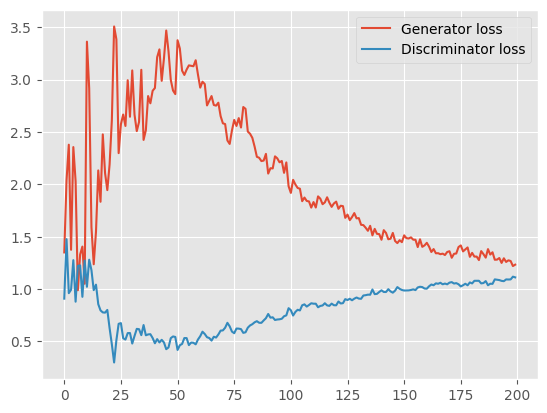

In [12]:
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label='Generator loss')
losses_d = [fl.item() for fl in losses_d]
plt.plot(losses_d, label='Discriminator loss')
plt.legend()

### 생성된 이미지 출력

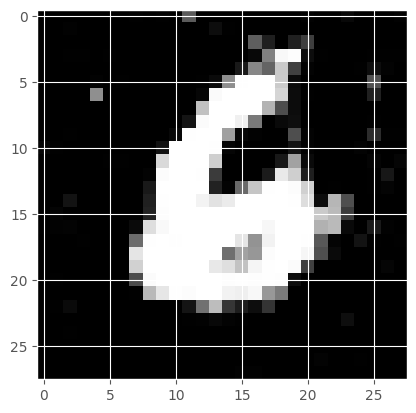

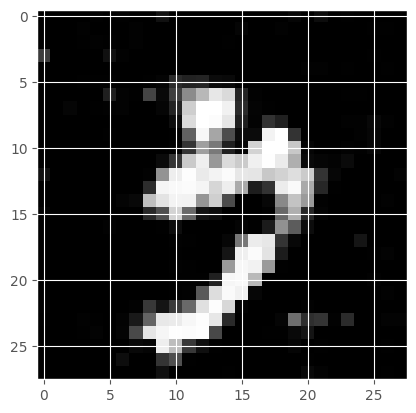

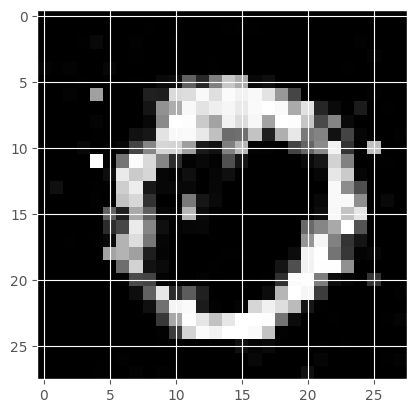

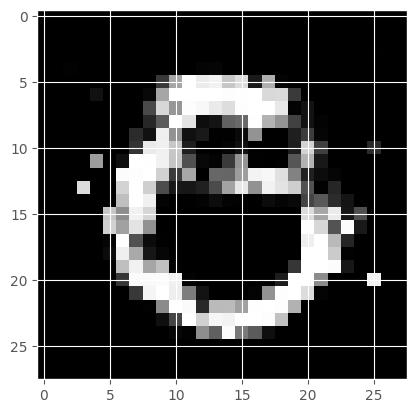

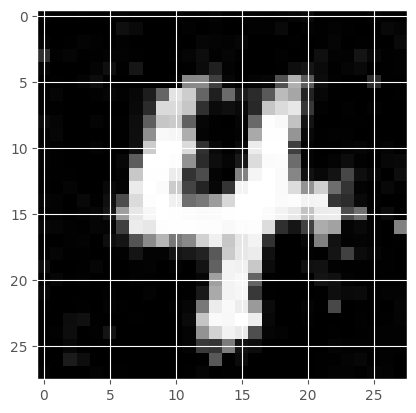

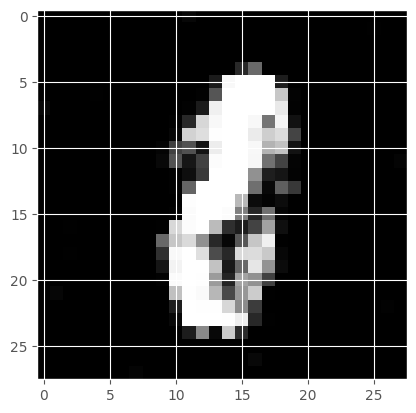

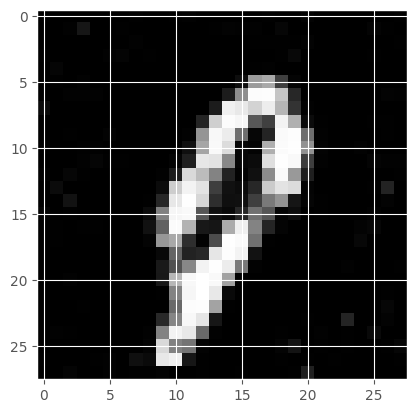

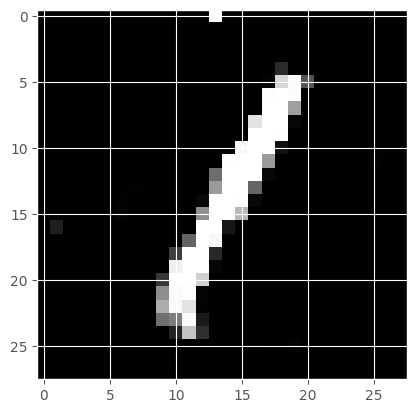

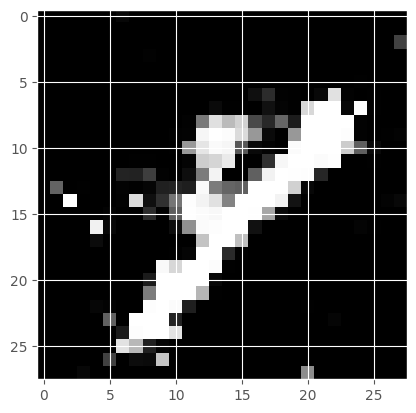

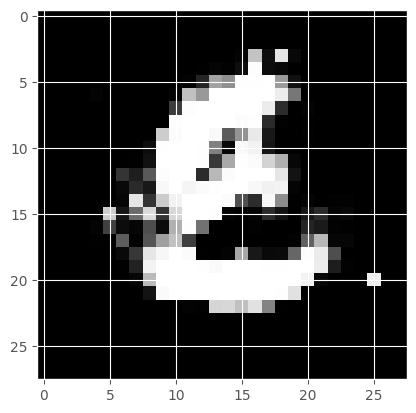

In [15]:
fake_images = generator(torch.randn(b_size, nz).to(device))
import numpy as np
for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28,28))
  plt.imshow(fake_images_img, cmap='gray')
  plt.savefig('/content/drive/MyDrive/Euron-Data/chap13/img/fake_images_img'+str(i)+'.png')
  plt.show()